In [109]:
import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
pd.set_option('display.max_rows', None)

In [2]:
df_read = pd.read_csv('postings.csv')

In [5]:
df_read.head(5)

,job_id,company_name,title,description,max_salary,pay_period,location,company_id,views,med_salary,...,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,normalized_salary,zip_code,fips
0,921716,Corcoran Sawyer Smith,Marketing Coordinator,Job descriptionA leading real estate firm in N...,20.0,HOURLY,"Princeton, NJ",2774458.0,20.0,NaN,...,Requirements: \n\nWe are seeking a College or ...,1.713398e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,38480.0,8540.0,34021.0
1,1829192,NaN,Mental Health Therapist/Counselor,"At Aspen Therapy and Wellness , we are committ...",50.0,HOURLY,"Fort Collins, CO",NaN,1.0,NaN,...,NaN,1.712858e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,83200.0,80521.0,8069.0
2,10998357,The National Exemplar,Assitant Restaurant Manager,The National Exemplar is accepting application...,65000.0,YEARLY,"Cincinnati, OH",64896719.0,8.0,NaN,...,We are currently accepting resumes for FOH - A...,1.713278e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,55000.0,45202.0,39061.0
3,23221523,"Abrams Fensterman, LLP",Senior Elder Law / Trusts and Estates Associat...,Senior Associate Attorney - Elder Law / Trusts...,175000.0,YEARLY,"New Hyde Park, NY",766262.0,16.0,NaN,...,This position requires a baseline understandin...,1.712896e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,157500.0,11040.0,36059.0
4,35982263,NaN,Service Technician,Looking for HVAC service tech with experience ...,80000.0,YEARLY,"Burlington, IA",NaN,3.0,NaN,...,NaN,1.713452e+12,NaN,0,FULL_TIME,USD,BASE_SALARY,70000.0,52601.0,19057.0


In [103]:
salary_col = 'normalized_salary'

In [115]:
print("Salary Summary:")
print(f"Min:  {df_read[salary_col].min()}")
print(f"Max:  {df_read[salary_col].max()}")
print(f"Mean: {df_read[salary_col].mean():.2f}")
print(f"Null count: {df_read[salary_col].isnull().sum()}")

Salary Summary:
Min:  0.0
Max:  535600000.0
Mean: 205327.04
Null count: 87776



Salary Buckets:
salary_bucket
<25K         611
25-50K      7792
50-75K      7643
75-100K     6030
100-150K    8521
150-200K    3596
200-300K    1482
300-500K     295
500K-1M       65
1M+           38
Name: count, dtype: int64


C:\Users\chris\anaconda3\Lib\site-packages\seaborn\categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


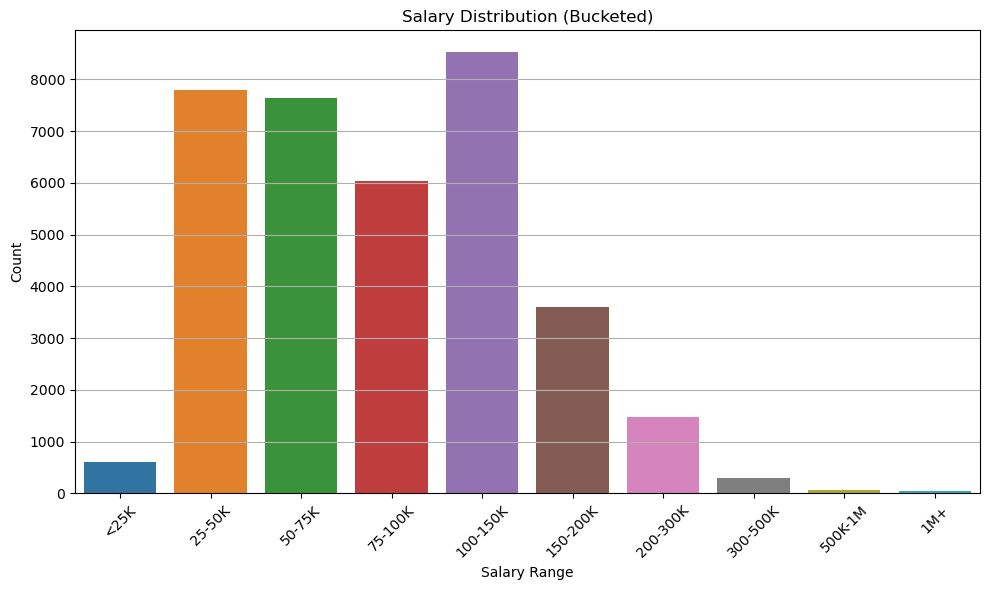

In [119]:
df_clean = df_read[df_read[salary_col].notnull()].copy()

bins = [0, 25000, 50000, 75000, 100000, 150000, 200000, 300000, 500000, 1_000_000, float('inf')]
labels = [
    '<25K', '25-50K', '50-75K', '75-100K', '100-150K',
    '150-200K', '200-300K', '300-500K', '500K-1M', '1M+'
]
df_clean['salary_bucket'] = pd.cut(df_clean[salary_col], bins=bins, labels=labels, right=False)

# Show counts per bucket
print("\nSalary Buckets:")
print(df_clean['salary_bucket'].value_counts().sort_index())

# Plot the distribution of buckets
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='salary_bucket', order=labels)
plt.title('Salary Distribution (Bucketed)')
plt.xlabel('Salary Range')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True, axis='y')
plt.show()

In [7]:
df = df_read[['company_name','title','description','min_salary','max_salary','pay_period','formatted_work_type','currency','normalized_salary','formatted_experience_level']]

In [9]:
df = df[df.formatted_work_type == 'Full-time']

In [11]:
df = df[df.currency == 'USD']

In [13]:
df = df.dropna(subset=['company_name'])
#df = df.dropna(subset=['zip_code'])

In [15]:
df = df.dropna(subset=['normalized_salary'])
df = df[df['normalized_salary'] > 15000]

In [17]:
# fix low salaries
df['annual_salary'] = np.where((df.normalized_salary < 30000) & (df.formatted_experience_level == 'Mid-Senior level') & (df.pay_period == 'YEARLY'),
    df.normalized_salary * 12, df.normalized_salary)

In [19]:
# fix high salaries
df['annual_salary'] = np.where((df.max_salary > 50000) & (df.normalized_salary > df.max_salary * 2), df.max_salary, df.normalized_salary)
df = df[df['annual_salary'] < 10000000]

In [21]:
#df.sort_values(by='normalized_salary', ascending=False).head(100)
df.sort_values(by='annual_salary', ascending=False).head(10)

,company_name,title,description,min_salary,max_salary,pay_period,formatted_work_type,currency,normalized_salary,formatted_experience_level,annual_salary
116367,Goliath Partners,Quantitative Researcher,Goliath Partners is working with a global prop...,700000.0,1200000.0,YEARLY,Full-time,USD,950000.0,Mid-Senior level,950000.0
4781,"Platinum Legal Search Group, LLC",Partner (& Groups w/ Portable Business for Top...,We're recruiting for a Top Law Firm seeking Pa...,350000.0,1500000.0,YEARLY,Full-time,USD,925000.0,NaN,925000.0
4735,"Platinum Legal Search Group, LLC",Partner (& Groups w/ Portable Business for Top...,We're recruiting for a Top Law Firm seeking Pa...,350000.0,1500000.0,YEARLY,Full-time,USD,925000.0,NaN,925000.0
91967,"Platinum Legal Search Group, LLC","Corporate, Litigation, Intellectual Property ,...",We're recruiting for a Top Law Firm seeking Pa...,350000.0,1500000.0,YEARLY,Full-time,USD,925000.0,NaN,925000.0
4908,"Platinum Legal Search Group, LLC",Partner (& Groups w/ Portable Business for Top...,We're recruiting for a Top Law Firm seeking Pa...,350000.0,1500000.0,YEARLY,Full-time,USD,925000.0,NaN,925000.0
113069,Goldman Lloyds,Head of Front Office Technology,Job Title: Head of Front Office Technology\nCo...,750000.0,1000000.0,YEARLY,Full-time,USD,875000.0,NaN,875000.0
117057,Goliath Partners,Quantitative Researcher,Goliath has partnered with a well concealed ye...,650000.0,1000000.0,YEARLY,Full-time,USD,825000.0,Mid-Senior level,825000.0
115087,Radley James,Network Engineer,"**PAYING UP TO $750,000 TOTAL COMPENSATION****...",750000.0,750000.0,YEARLY,Full-time,USD,750000.0,Mid-Senior level,750000.0
54411,Emburse,Senior Sales Account Executive - Enterprise,At Emburse our mission is to help make our use...,NaN,NaN,YEARLY,Full-time,USD,750000.0,Mid-Senior level,750000.0
115360,Radley James,Python Developer,**Offering up to $650K and a comprehensive rel...,750000.0,750000.0,YEARLY,Full-time,USD,750000.0,Mid-Senior level,750000.0


In [23]:
df.shape

(28471, 11)

In [25]:
df = pd.get_dummies(df, columns=['pay_period'])

In [ ]:
#df['log_salary'] = np.log1p(df['annual_salary'])

In [27]:
pay_period_features = df[['pay_period_BIWEEKLY', 'pay_period_HOURLY',
                          'pay_period_MONTHLY', 'pay_period_WEEKLY', 'pay_period_YEARLY']]
y = df['annual_salary'].values

In [29]:
#df['text'] = df['company_name'] + ' ' + df['title']
#df['text'] = df['text'].astype(str)

In [31]:
df["text"] = df["title"].fillna("") 
df["text"] = df["title"].astype(str)

In [33]:
text_data = df['text']

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [37]:
def get_bert_embeddings(texts, tokenizer, model, batch_size=32):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i+batch_size]
            inputs = tokenizer(batch.tolist(), return_tensors="pt", padding=True, truncation=True, max_length=20)
            outputs = model(**inputs)
            cls_embeddings = outputs.last_hidden_state[:, 0, :]  # CLS token
            embeddings.append(cls_embeddings.cpu().numpy())
    return np.vstack(embeddings)

In [39]:
bert_embeddings = get_bert_embeddings(text_data, tokenizer, bert_model)

In [ ]:
#X = bert_embeddings

In [41]:
X = np.hstack((bert_embeddings, pay_period_features.values))

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

In [79]:
xgb_model = xgb.XGBRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

In [81]:
#model = xgb.XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [83]:
y_pred = model.predict(X_test)
#y_pred = xgb_model.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"XGBoost RMSE: {rmse:,.0f}")

XGBoost RMSE: 46,795


In [85]:
r2_score(y_test, y_pred)

0.4746700628785828

In [87]:
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

rmse_train = mean_squared_error(y_train, y_train_pred, squared=False)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)

print(f"Train RMSE: {rmse_train:,.0f}")
print(f"Test RMSE: {rmse_test:,.0f}")

Train RMSE: 19,307
Test RMSE: 46,795


In [61]:
xgb_model_cv = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [69]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

In [71]:
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1],
    'max_depth': [4, 6],
    'subsample': [0.8],
    'colsample_bytree': [0.8],
    'reg_alpha': [0, 1, 5],
    'reg_lambda': [1, 5, 10]
}

In [73]:
grid_search = GridSearchCV(
    estimator=xgb_model_cv,
    param_grid=param_grid,
    scoring=rmse_scorer,
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8],
                         'learning_rate': [0.05, 0.1], 'max_depth': [4, 6],
                         'n_estimators': [100, 200], 'reg_alpha': [0, 1, 5],
                         'reg_lambda': [1, 5, 10], 'subsample': [0.8]},
             scoring=make_scorer(mean_squared_error, greater_is_better=False, squared=False),
             verbose=1)

In [77]:
print("Best Parameters:", grid_search.best_params_)
print("Best CV RMSE:", -grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse_test = mean_squared_error(y_test, y_pred, squared=False)
print("Test RMSE:", rmse_test)

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'reg_alpha': 5, 'reg_lambda': 10, 'subsample': 0.8}
Best CV RMSE: 42815.41310574304
Test RMSE: 45777.88736818585


In [99]:
df['annual_salary'].describe()

count     28471.000000
mean      99546.994261
std       62207.045562
min       15080.000000
25%       55120.000000
50%       85000.000000
75%      127500.000000
max      950000.000000
Name: annual_salary, dtype: float64

In [ ]:
job_titles = df['title'].tolist()

In [ ]:
job_title_to_embedding = {job: emb for job, emb in zip(job_titles, bert_embeddings)}

# Save to file
import joblib
joblib.dump(job_title_to_embedding, "bert_job_embeddings.pkl")

In [ ]:
joblib.dump(xgb_model, 'xgb_salary_model.pkl')